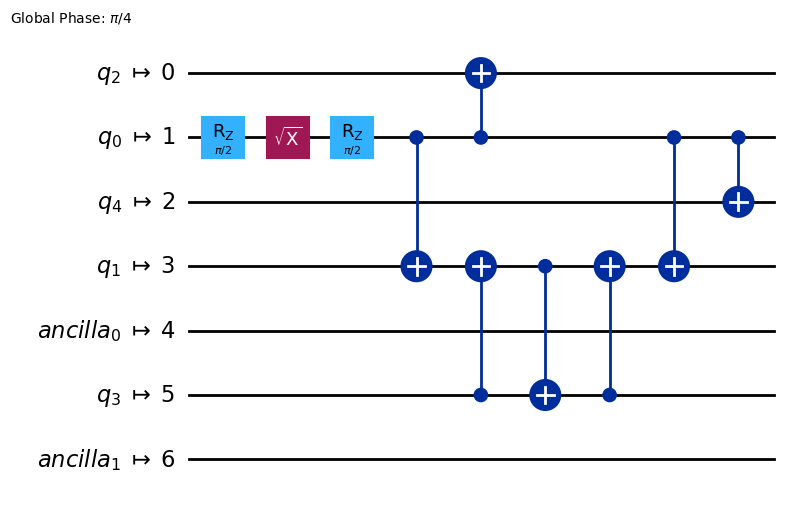

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from q_env_config import circuit_context, q_env_config
from rl_qoc import QuantumEnvironment, ContextAwareQuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction

circuit_context.draw("mpl")

Selected backend: fake_jakarta backend version 2


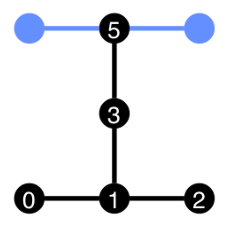

In [3]:
from qiskit.visualization import plot_circuit_layout, plot_gate_map

if q_env_config.backend is not None and circuit_context.layout is not None:
    fig = plot_circuit_layout(
        circuit_context, q_env_config.backend_config.backend, view="physical"
    )
    print(
        "Selected backend:",
        q_env_config.backend.name,
        "backend version",
        q_env_config.backend_config.backend.version,
    )
elif q_env_config.backend is not None and q_env_config.backend.coupling_map.size() != 0:
    fig = plot_gate_map(q_env_config.backend)
    print(
        "Selected backend:",
        q_env_config.backend.name,
        "backend version",
        q_env_config.backend_config.backend.version,
    )
else:
    fig = None
    print("No backend selected, cannot plot circuit layout or gate map")

fig

In [4]:
use_context = False
if use_context:
    q_env = ContextAwareQuantumEnvironment(
        q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironment(q_env_config)
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

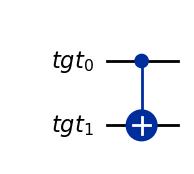

In [5]:
q_env.baseline_circuits[0].draw("mpl", style="iqp")

In [8]:
from rl_qoc.helper_functions import load_from_yaml_file
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = file_name

agent_config = load_from_yaml_file(file_location)

In [12]:
from rl_qoc.ppo import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env)
total_updates = 100
target_fidelities = [0.9]
lookback_window = 20
anneal_learning_rate = False

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

In [13]:
ppo_agent.train(ppo_config, train_settings)

100%|██████████| 100/100 [00:31<00:00,  3.14it/s]

2024-06-21 11:57:30 INFO Target fidelity 0.9 achieved: Update 21, Hardware Runtime: 1.1 sec, Simulation Train Time: 0.1302 mins, Shots Used 499,200


{'env_ident_str': 'gate_calibration_cx-gate_physical_qubits_1-2',
 'reward_method': 'state',
 'training_constraint': TotalUpdates(total_updates=100),
 'avg_reward': [0.8661287446504996,
  0.8248828125000002,
  0.9416904422253926,
  0.8737517831669046,
  0.8259375000000003,
  0.8177083333333335,
  0.8631419400855924,
  0.9376562500000002,
  0.8312109375000003,
  0.8241351640513553,
  0.8752604166666669,
  0.8365384615384619,
  0.8455468750000001,
  0.8434375000000002,
  0.8756597222222227,
  0.8340234375000002,
  0.8372656250000002,
  0.8496180555555557,
  0.8408333333333335,
  0.8689583333333335,
  0.8700694444444443,
  0.8731640625000001,
  0.8938671874999999,
  0.889666547788873,
  0.8374479166666668,
  0.8668402777777778,
  0.8823828125,
  0.8749305555555555,
  0.8675998573466477,
  0.8655078125,
  0.879479166666667,
  0.872986111111111,
  0.8976462196861626,
  0.8375000000000002,
  0.8514930555555558,
  0.8138020833333336,
  0.8854315263908705,
  0.8867708333333337,
  0.84392831669

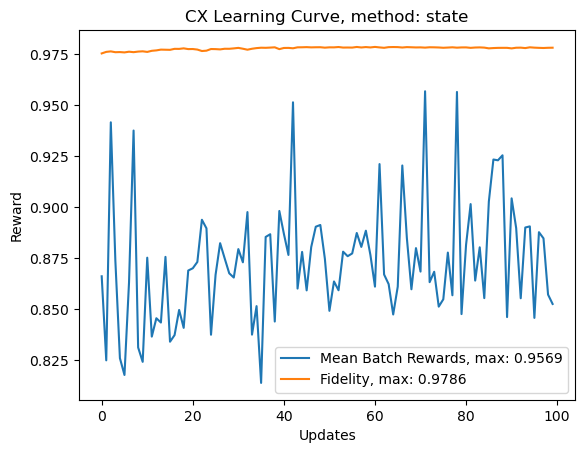

In [16]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method}"
)
plt.legend()
plt.show()

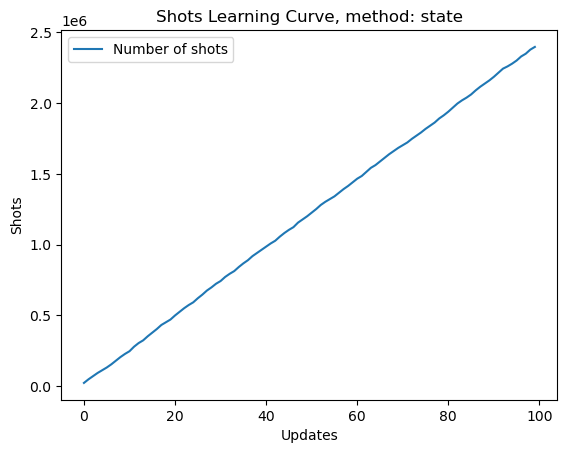

In [17]:
plt.plot(np.cumsum(q_env.total_shots), label="Number of shots")
plt.xlabel("Updates")
plt.ylabel("Shots")
plt.title(f"Shots Learning Curve, method: {q_env.config.reward_method}")
plt.legend()

In [21]:
convergence_iteration = 60
print(
    "Number of shots required for convergence:",
    np.cumsum(q_env.total_shots[:convergence_iteration]),
)

Number of shots required for convergence: [  22400   48000   70400   92800  112000  131200  153600  179200  204800
  227200  246400  278400  304000  323200  352000  377600  403200  432000
  451200  470400  499200  524800  550400  572800  592000  620800  646400
  675200  697600  723200  742400  771200  793600  812800  841600  867200
  889600  918400  940800  963200  985600 1008000 1027200 1056000 1081600
 1104000 1123200 1155200 1177600 1200000 1225600 1251200 1280000 1302400
 1321600 1340800 1366400 1392000 1414400 1440000]


In [22]:
from qiskit.quantum_info import average_gate_fidelity
from qiskit.quantum_info import Operator

print(
    "Fidelity of the final circuit:",
    average_gate_fidelity(
        Operator(q_env.circuits[0].assign_parameters(q_env.optimal_action).decompose()),
        Operator(q_env.target.gate),
    ),
)

Fidelity of the final circuit: 1.0


In [ ]:
from qiskit_aer import AerSimulator

backend = AerSimulator(coupling_map=[[0, 1], [1, 0]])
backend.coupling_map.size()

In [ ]:
from rl_qoc.helper_functions import remove_unused_wires
from qiskit.quantum_info import Operator

remove_unused_wires(
    q_env._ideal_pubs[8][0].remove_final_measurements(inplace=False)
).draw("mpl")

In [ ]:
remove_unused_wires(q_env._pubs[8][0].remove_final_measurements(inplace=False)).draw(
    "mpl"
)

In [ ]:
q_env.std_action

In [ ]:
ppo_agent.training_results["std_action"]

In [ ]:
plt.plot(ppo_agent.training_results["std_action"])

In [ ]:
plt.plot(ppo_agent.training_results["mean_action"])

In [ ]:
from qiskit import transpile
from qiskit import QuantumCircuit

qc = QuantumCircuit(1)
qc.h(0)

transpiled_qc = transpile(qc, backend=q_env_config.backend, optimization_level=0)
transpiled_qc.draw("mpl")

In [ ]:
q_env.compute_benchmarks(
    q_env.circuits[0].copy(),
    np.array(
        [np.pi * np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0])] * q_env.batch_size
    ),
)